# Test and Analyze Model Robustness with NRTK and XAITK for the Object Detection Task

## Overview
This guide demonstrates how to integrate the Natural Robustness Toolkit (NRTK) with XAITK-Saliency to assess model robustness
and understand why models fail. Unlike traditional robustness testing, which only measures performance degradation, this
approach reveals how the features your model focuses on change under perturbation, allowing you to interpret and act on the
results as they are generated.

This notebook is created from [Explaining model robustness: combining saliency maps and natural robustness testing using XAITK and NRTK](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/13476/3052320/Explaining-model-robustness--combining-saliency-maps-and-natural-robustness/10.1117/12.3052320.short).

## What You'll Accomplish

* Apply systematic perturbations and generate interpretable saliency maps.
* Recognize robust vs. sensitive model behaviors as you test.
* Quantify saliency changes and understand what they indicate in an object detection task. 
* Make informed decisions about model deployment and improvement.

### Important note prior to running this notebook

This notebook requires atleast 32GB of CPU RAM (and enough swap space if using linux-based systems) to run this notebook without experiencing any kernel crashes caused by memory issues.

## Table of Contents

* [Set Up the Environment](#set-up-the-environment)
* [Define Model and Dataset](#define-model-and-dataset)
* [Configure Your NRTK Perturbation Strategy](#configure-your-nrtk-perturbation-strategy)
    * [Gaussian Blur Perturbation](#gaussian-blur-perturbation)
    * [Salt Noise Perturbation](#salt-noise-perturbation)
* [Evaluate Perturbed Datasets](#evaluate-perturbed-datasets)
    * [Compute Mean Average Precision Metric](#compute-mean-average-precision-metric)
    * [Generate Item Response Curves](#generate-item-response-curves)
* [Generate and Evaluate Saliency Maps](#generate-and-evaluate-saliency-maps)
    * [Initialize D-RISE algorithm](#initialize-d-rise-algorithm)
    * [Compute Saliency Maps and Related Metrics](#compute-saliency-maps-and-related-metrics)
    * [Interpretability Analysis](#interpretability-analysis)
* [Conclusion](#conclusion) 

## Set Up the Environment 

In [1]:
import sys

!{sys.executable} -m pip install -qU pip
print("Installing nrtk with optional dependencies...")
!{sys.executable} -m pip install -q nrtk[pybsm,maite,tools,scikit-image,headless]
print("Install huggingface transformers and datasets")
!{sys.executable} -m pip install -q transformers datasets
print("Installing ultralytics...")
!{sys.executable} -m pip install -q ultralytics
print("Installing tabulate...")
!{sys.executable} -m pip install -q tabulate
print("Installing xaitk-saliency")
!{sys.executable} -m pip install -q xaitk_saliency
print("Done!")

Installing nrtk with optional dependencies...
Install huggingface transformers and datasets
Installing ultralytics...
Installing tabulate...
Installing xaitk-saliency
Done!


In [2]:
from __future__ import annotations  # noqa: F404

# Python imports
import os
import random
import warnings
from collections.abc import Sequence
from pathlib import Path

# 3rd party imports
import matplotlib.pyplot as plt
import numpy as np
import torch

# Seed setting for reproducibility
seed = 123
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.default_rng(seed)
torch.manual_seed(seed)

%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations

warnings.filterwarnings("ignore")

# Add notebook utils to path
notebook_dir = Path().absolute()
utils_path = notebook_dir / "utils"
if str(utils_path) not in sys.path:
    sys.path.insert(0, str(utils_path))

## Define Model and Dataset

The NRTK-XAITK workflow depends on [HuggingFace](https://huggingface.co/) (HF) to download the required model. To align the dataset/model to the Object Detection evaluation workflow, we need to adapt the HF model to be compliant with [MAITE](https://github.com/mit-ll-ai-technology/maite) protocols. In the section below, we define the HuggingFace-MAITE adapters for the [VisDrone](https://github.com/VisDrone/VisDrone-Dataset) dataset and HF pretrained-model for the Object Detection task.

**Note**: Make sure to set the local, absolute paths to the ``images`` and ``annotations`` subfolders from the VisDrone dataset split in the cell below.

In [3]:
from object_detection.dataset import (
    VisDroneObjectDetectionDataset,
    stratified_sample_dataset,
)
from object_detection.model import MaiteYOLODetector

# Check if CUDA is available and set the device accordingly
CUDA_AVAILABLE = torch.cuda.is_available()
device = "cuda" if CUDA_AVAILABLE else "cpu"

# Make sure to set the local paths to the VisDrone dataset here
VISDRONE_DIR = "/path/to/visdrone"
IMAGES_DIR = VISDRONE_DIR + "/images"
ANNOTATIONS_DIR = VISDRONE_DIR + "/annotations"

# Create a isDroneObjectDetectionDataset instance
# This will wrap the VisDrone dataset to comply with the MAITE Dataset protocol
maite_dataset = VisDroneObjectDetectionDataset(
    images_dir=IMAGES_DIR,
    annotations_dir=ANNOTATIONS_DIR,
)
maite_dataset = stratified_sample_dataset(dataset=maite_dataset, subset_size=25)
print(f"Number of images: {len(maite_dataset)}")
example_img_id = 15

Number of images: 26


In [4]:
import urllib

import ultralytics

# Create a MAITE detector instance
# This will wrap a YOLO model to comply with the MAITE Object Detection protocol
ultralytics.checks()
print("Downloading model...")
model_path = "./yolo11l-visdrone.pt"
_ = urllib.request.urlretrieve(
    "https://huggingface.co/erbayat/yolov11l-visdrone/resolve/main/yolo11l-visdrone.pt?download=true",
    model_path,
)

model = ultralytics.YOLO(model_path)

# set model parameters
model.overrides["conf"] = 0.25  # NMS confidence threshold
model.overrides["iou"] = 0.5  # NMS IoU threshold
model.overrides["agnostic_nms"] = False  # NMS class-agnostic
model.overrides["max_det"] = 1000  # maximum number of detections per image
maite_detector = MaiteYOLODetector(model=model)

Ultralytics 8.3.85 🚀 Python-3.10.18 torch-2.8.0+cu128 CUDA:0 (Quadro RTX 5000, 15928MiB)
Setup complete ✅ (40 CPUs, 251.5 GB RAM, 554.1/914.7 GB disk)


##  Configure Your NRTK Perturbation Strategy

### Gaussian Blur Perturbation

To perturb the input dataset with the Gaussian Blur operation, we set up a sequence of perturber configurations using the GaussianBlurPerturber that ranges across five blur kernel sizes (ksize). Each perturber configuration is applied to the entire dataset to create five new perturbed datasets.

In [5]:
import math

from nrtk.impls.perturb_image.photometric.blur import GaussianBlurPerturber

# Parameters for Gaussian blur perturbation sweep
SWEEP_LOW = 1  # minimum kernel size
SWEEP_HIGH = 41  # maximum kernel size
SWEEP_COUNT = 5  # number of values to sample

# Generate list of odd kernel sizes for Gaussian blur
blur_perturbation_values = np.linspace(
    SWEEP_LOW,
    SWEEP_HIGH,
    SWEEP_COUNT,
    endpoint=True,
)
blur_augmentations = []
for p in blur_perturbation_values:
    p = int(round(p))
    # Gaussian blur requires odd kernel sizes to maintain
    # symmetric padding along the edges to preserve dimensionality.
    p = int(math.floor(p))
    if p % 2 == 0:
        p += 1
    blur_augmentations.append(GaussianBlurPerturber(ksize=p))

### Gaussian perturbation example

To understand each perturber's setting, we visualize a sample image from each dataset.

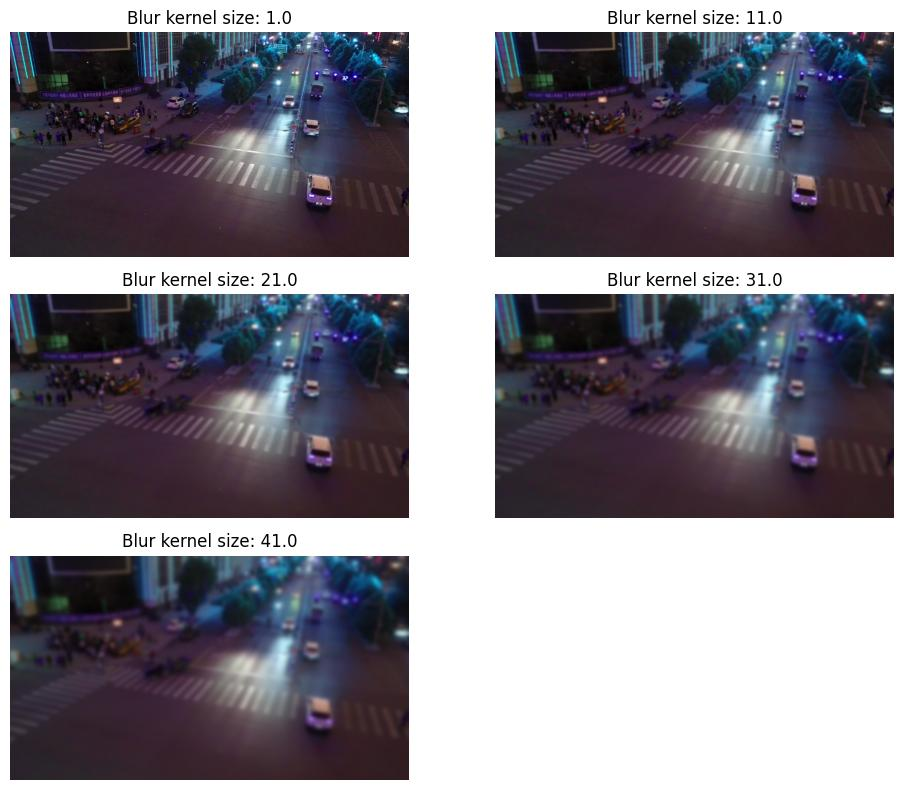

In [6]:
# Visualize the perturbations on a sample image
img = maite_dataset[example_img_id][0].transpose(1, 2, 0)

fig, ax = plt.subplots(3, 2, figsize=(10, 8))
for idx, p in enumerate(blur_perturbation_values):
    ax[idx // 2, idx % 2].set_title(f"Blur kernel size: {p}")
    ax[idx // 2, idx % 2].imshow(blur_augmentations[idx](img)[0])
    _ = ax[idx // 2, idx % 2].axis("off")
fig.delaxes(ax[2, 1])
plt.tight_layout()

###  Salt Noise Perturbation

To apply salt noise to the input dataset, we set up a sequence of perturber configurations using the SaltNoisePerturber that ranges across five salt noise amount values. Each perturber configuration is applied on the entire dataset to create five new perturbed datasets.

In [7]:
from nrtk.impls.perturb_image.photometric.noise import SaltNoisePerturber

# Parameters for salt noise perturbation sweep
SWEEP_LOW = 0.0  # minimum salt noise amount
SWEEP_HIGH = 0.50  # maximum salt noise amount
SWEEP_COUNT = 5  # number of values to sample

# Generate augmentations using salt noise with increasing intensity
noise_perturbation_values = np.linspace(
    SWEEP_LOW,
    SWEEP_HIGH,
    SWEEP_COUNT,
    endpoint=True,
)
salt_augmentations = [SaltNoisePerturber(amount=p) for p in noise_perturbation_values]

### Salt noise perturbation example

To understand each perturber's setting, we visualize a sample image from each dataset.

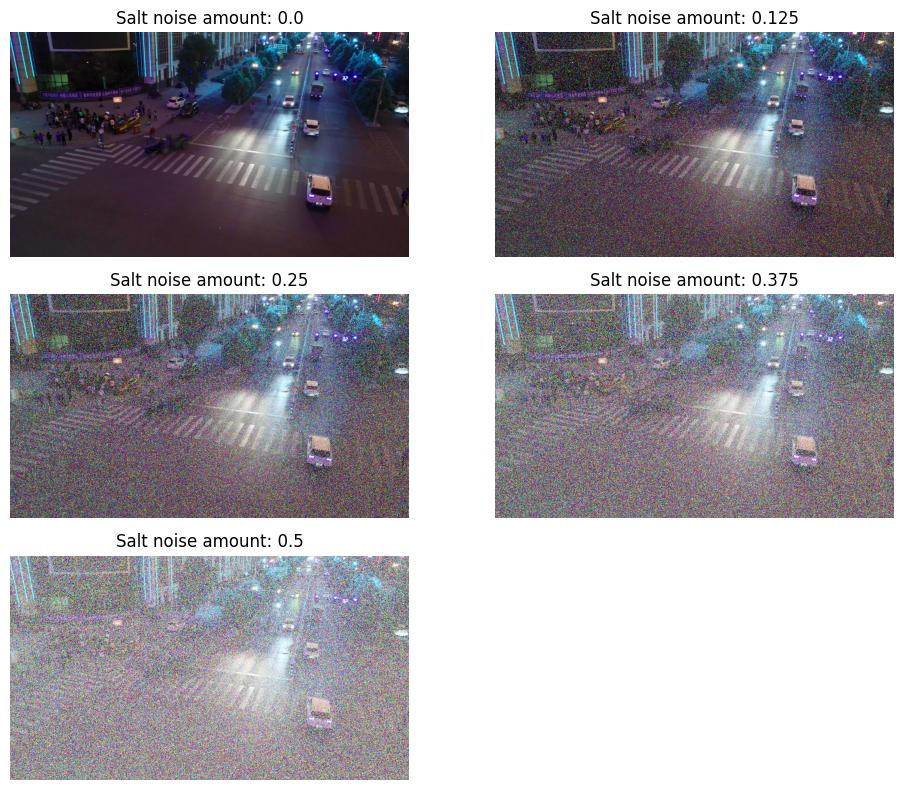

In [8]:
# Visualize the perturbations on a sample image
img = maite_dataset[example_img_id][0].transpose(1, 2, 0)

fig, ax = plt.subplots(3, 2, figsize=(10, 8))
for idx, p in enumerate(noise_perturbation_values):
    ax[idx // 2, idx % 2].set_title(f"Salt noise amount: {p}")
    ax[idx // 2, idx % 2].imshow(salt_augmentations[idx](image=img)[0])
    _ = ax[idx // 2, idx % 2].axis("off")
fig.delaxes(ax[2, 1])
plt.tight_layout()

##  Evaluate Perturbed Datasets

### Compute Mean Average Precision Metric
For understanding the overall impact of the two different perturbers on model performance, we compute the model's mean average precision metric across the various perturbed datasets. For this computation, we use a MAITE-compliant accuracy metric and evaluation workflow.

In [9]:
from maite.interop.metrics.torchmetrics import TMDetectionMetric
from maite.tasks import evaluate
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from nrtk.interop import MAITEDetectionAugmentation

# Initialize mAP metric (Maite-compatible)
tm_metric = MeanAveragePrecision(
    box_format="xyxy",
    iou_type="bbox",
    iou_thresholds=[0.5],
    rec_thresholds=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    max_detection_thresholds=[1, 10, 100],
    class_metrics=True,
    extended_summary=False,
    average="macro",
)
maite_map_metric = TMDetectionMetric(tm_metric)

# List to store results for Gaussian blur perturbation
gauss_blur_perturbed_metrics = []
for idx, aug in enumerate(blur_augmentations):
    # Create a MAITEDetectionAugmentation instance for each perturbation
    maite_aug = MAITEDetectionAugmentation(augment=aug, augment_id=f"GaussianBlurPerturber_{idx}")
    # reset the metric object for each dataset
    maite_map_metric.reset()
    result, _, _ = evaluate(
        model=maite_detector,
        metric=maite_map_metric,
        dataset=maite_dataset,
        augmentation=maite_aug,
    )
    gauss_blur_perturbed_metrics.append(result)

# List to store results for Gaussian blur perturbation
salt_noise_perturbed_metrics = []
for idx, aug in enumerate(salt_augmentations):
    # Create a MAITEDetectionAugmentation instance for each perturbation
    maite_aug = MAITEDetectionAugmentation(augment=aug, augment_id=f"SaltNoisePerturber_{idx}")
    # reset the metric object for each dataset
    maite_map_metric.reset()
    result, _, _ = evaluate(
        model=maite_detector,
        metric=maite_map_metric,
        dataset=maite_dataset,
        augmentation=maite_aug,
    )
    salt_noise_perturbed_metrics.append(result)

100%|██████████| 26/26 [00:05<00:00,  5.06it/s]


### Generate Item Response Curves

The mean average precision values (generated above) are visualized as item-response curves to understand the robustness of the model to varying degree of Blur and Salt noise perturbations. From the plots below, we can see a sharp drop in accuracy of the model on increasing the perturbation intensity.

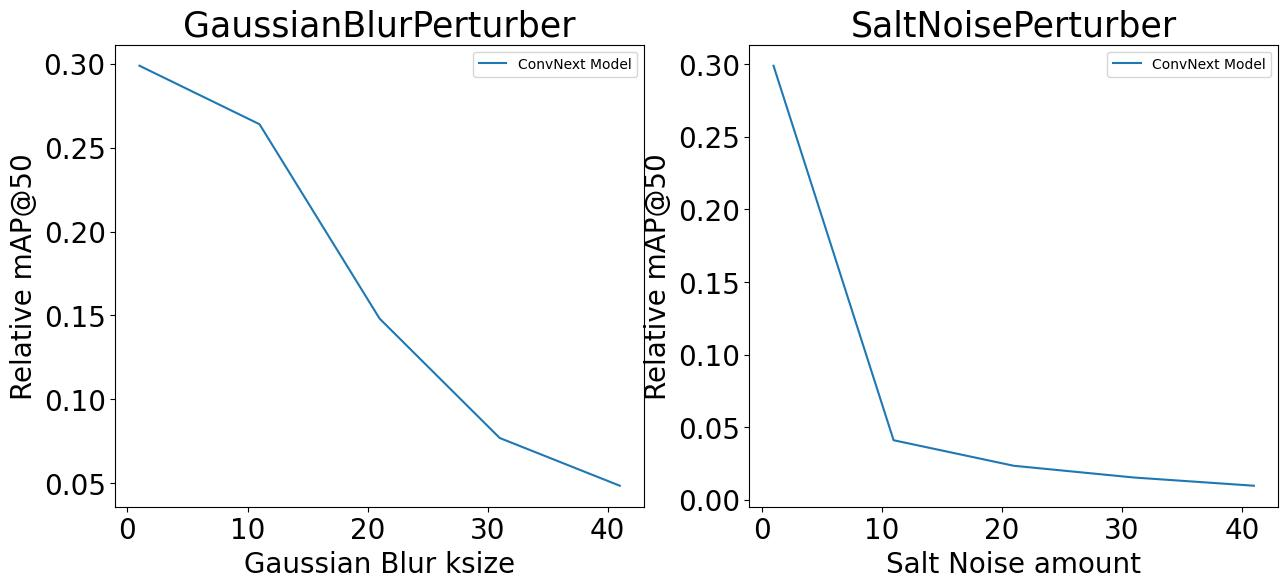

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create 1-row, 2-column grid

_ = axes[0].plot(
    blur_perturbation_values,
    [m["map_50"] for m in gauss_blur_perturbed_metrics],
    label="ConvNext Model",
)
axes[0].set_title("GaussianBlurPerturber", fontsize=25)
axes[0].set_xlabel("Gaussian Blur ksize", fontsize=20)
axes[0].set_ylabel("Relative mAP@50", fontsize=20)
axes[0].tick_params(axis="both", which="major", labelsize=20)
axes[0].legend()

# Salt noise results
_ = axes[1].plot(
    blur_perturbation_values,
    [m["map_50"] for m in salt_noise_perturbed_metrics],
    label="ConvNext Model",
)
axes[1].set_title("SaltNoisePerturber", fontsize=25)
axes[1].set_xlabel("Salt Noise amount", fontsize=20)
axes[1].set_ylabel("Relative mAP@50", fontsize=20)
axes[1].tick_params(axis="both", which="major", labelsize=20)
axes[1].legend()

## Generate and Evaluate Saliency Maps

###  Initialize D-RISE algorithm

In [11]:
from xaitk_saliency.impls.gen_object_detector_blackbox_sal.drise import DRISEStack

# Saliency prep
model_mean = [95, 96, 93]

blackbox_fill = np.uint8(np.asarray(model_mean) * 255)
gen_drise = DRISEStack(n=150, s=7, p1=0.7, seed=0, threads=8)
gen_drise.fill = blackbox_fill.astype(int)

### Metric Helper/Util Functions

First, we set up the XAITK-Saliency metric helper/utility functions.

In [12]:
from dataclasses import dataclass, field

import matplotlib.pyplot as plt
import numpy as np
from object_detection.dataset import YOLODetectionTarget
from xaitk_saliency.impls.saliency_metric.entropy import Entropy
from xaitk_saliency.utils.sal_metrics import (
    compute_ground_truth_coverage,
    compute_iou_coverage,
    compute_saliency_coverage,
    compute_ssd,
    compute_xcorr,
)


def get_selected_dets_np(
    dets: Sequence[YOLODetectionTarget],
    indices: Sequence[int],
) -> tuple[np.ndarray, np.ndarray]:
    """Get bounding boxes and scores for specific detection indices.

    :param dets: Iterable of detected objects from YOLOModelWrapper.
    :param indices: List of indices of the detections to select.
    :return: Tuple of:
        - Bounding boxes in (N, 4) format (xyxy).
        - Confidence scores in (N, C) format (C = number of classes).
    """
    dets = list(dets)[0]  # Convert first iterable to list (assuming single image)

    all_bboxes = []
    all_scores = []

    for i, (bbox, class_scores) in enumerate(dets):
        if i in indices:
            x1, y1 = bbox.min_vertex
            x2, y2 = bbox.max_vertex
            all_bboxes.append([x1, y1, x2, y2])

            # Convert class scores to a fixed array format
            score_vector = np.zeros(10, dtype=np.float32)  # Assuming max 10 classes
            for cls_idx, score in class_scores.items():
                score_vector[cls_idx] = score

            all_scores.append(score_vector)

    # Convert to numpy arrays
    selected_bboxes = np.array(all_bboxes, dtype=np.float32) if all_bboxes else np.empty((0, 4))
    selected_scores = np.array(all_scores, dtype=np.float32) if all_scores else np.empty((0, 10))

    return selected_bboxes, selected_scores


@dataclass
class PerturbationResult:
    """Dataclass for storing perturbed image and associated results."""

    descriptor: str
    img: np.ndarray
    sal_maps: np.ndarray
    pred_class: int
    pred_prob: float


@dataclass
class SaliencyResults:
    """Dataclass for storing saliency map and associated results."""

    ref_img: np.ndarray
    ref_sal_maps: np.ndarray
    gt: int
    pred_class: int
    pred_prob: float
    perturbations: list[PerturbationResult] = field(default_factory=list)


def _compute_entropy_setup(sal_map: np.ndarray, m: str) -> float:
    if m == "entropy":
        compute_entropy = Entropy()
        return compute_entropy(sal_map)
    if m == "pos saliency entropy":
        compute_entropy = Entropy(clip_range=(0, 1))
        return compute_entropy(sal_map)
    if m == "neg saliency entropy":
        compute_entropy = Entropy(clip_range=(-1, 0))
        return compute_entropy(sal_map)
    return np.nan


def _compute_metric(sal_map: np.ndarray, ref_sal_map: np.ndarray, m: str) -> float | np.float64:  # noqa: C901
    if "entropy" in m:
        return _compute_entropy_setup(sal_map, m)
    if m == "ssd":
        return compute_ssd(sal_map, ref_sal_map)
    if m == "xcorr":
        return compute_xcorr(sal_map, ref_sal_map)
    if m == "iou_coverage":
        return compute_iou_coverage(sal_map, ref_sal_map)
    if m == "sal_coverage":
        return compute_saliency_coverage(sal_map, ref_sal_map)
    if m == "gt_coverage":
        return compute_ground_truth_coverage(sal_map, ref_sal_map)
    return np.nan


def create_binary_mask(bbox: Sequence[int], img_size: tuple[int, int]) -> np.ndarray:
    """Creates a binary mask where pixels inside the given bounding box are 1 and the rest are 0.

    Args:
        bbox (list or tuple): Bounding box in the form [x1, y1, x2, y2], where:
                              - (x1, y1) is the top-left corner.
                              - (x2, y2) is the bottom-right corner.
        img_size (tuple): Size of the image as (height, width).

    Returns:
        np.ndarray: A binary mask of shape (height, width), where pixels inside the bbox are 1.
    """
    # Unpack bounding box coordinates
    x1, y1, x2, y2 = map(int, bbox)  # Ensure integer values

    # Create an empty mask
    mask = np.zeros(img_size, dtype=np.uint8)

    # Set pixels inside the bounding box to 1
    mask[y1:y2, x1:x2] = 1

    return mask


def compute_iou(box1: torch.Tensor, boxes2: torch.Tensor) -> torch.Tensor:
    """Computes IoU (Intersection over Union) between a single box and multiple boxes.

    Args:
        box1 (torch.Tensor): Single bounding box (4,).
        boxes2 (torch.Tensor): Multiple bounding boxes (N, 4).

    Returns:
        torch.Tensor: IoU scores (N,).
    """
    # Compute intersection coordinates
    inter_x1 = torch.max(box1[0], boxes2[:, 0])
    inter_y1 = torch.max(box1[1], boxes2[:, 1])
    inter_x2 = torch.min(box1[2], boxes2[:, 2])
    inter_y2 = torch.min(box1[3], boxes2[:, 3])

    # Compute intersection area
    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)

    # Compute areas of both boxes
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # Compute union area
    union_area = area1 + area2 - inter_area

    # Compute IoU
    return inter_area / union_area.clamp(min=1e-6)


def get_best_iou_bbox(
    detection: torch.Tensor | Sequence,
    yolo_target: YOLODetectionTarget,
) -> tuple[torch.Tensor, torch.Tensor]:
    """Finds the ground truth bounding box from YOLODetectionTarget that has the highest IoU with the given detection.

    Args:
        detection (list or torch.Tensor): Bounding box in the form [x1, y1, x2, y2].
        yolo_target (YOLODetectionTarget): Object containing ground truth boxes.

    Returns:
        tuple: (best_bbox, best_label)
            - best_bbox (torch.Tensor): The ground truth bbox with the highest IoU.
            - best_label (torch.Tensor): The class label of the best bbox.
    """
    # Convert detection to a tensor if not already
    detection = torch.tensor(detection, dtype=torch.float32)

    # Extract ground truth bounding boxes
    gt_boxes = yolo_target.boxes  # Shape: (num_boxes, 4)

    # Compute IoU with all ground truth boxes
    ious = compute_iou(detection, gt_boxes)

    # Find the index of the highest IoU
    best_idx = int(torch.argmax(ious).item())
    # best_iou = ious[best_idx].item()

    # Retrieve the best matching bbox and label
    best_bbox = gt_boxes[best_idx]
    best_label = yolo_target.labels[best_idx]

    return best_bbox, best_label

### Saliency Generation

Following the metric utils setup, we loop through both the `GaussianBlurPerturber` and `SaltNoisePerturber` perturbed datasets to generate predictions, compute saliency maps, and compute the related metric values.

In [13]:
from scipy.stats import pearsonr

# Initialize tracking lists for results
class_names = ["pedestrian", "people", "bicycle", "car", "van", "truck", "tricycle", "awning-tricycle", "bus", "motor"]
threshold = 0.8  # Higher confidence threshold to reduce the amount of detections and decrease notebook execution time

results = {}
for transform in blur_augmentations + salt_augmentations:
    perturbation_type = transform.__class__.__name__
    perturb_param_name = "ksize" if perturbation_type == "GaussianBlurPerturber" else "amount"
    perturb_param_val = transform.ksize if perturbation_type == "GaussianBlurPerturber" else transform.amount

    perturb_key = f"{perturbation_type}_{perturb_param_name}_{perturb_param_val}"
    print(perturb_key)
    confs = np.empty(0)
    ssds = []
    xcorrs = []
    ious = []
    sal_coverages = []
    gt_coverages = []
    sal_maps = {}
    bboxes = {}
    truth_labels = {}
    truth_scores = {}
    perturbed_images = {}
    pred_scores = {}
    pred_labels = {}
    for i in range(len(maite_dataset)):
        # prep imagery
        ref_image, targets, metadata = maite_dataset[i]
        ref_image = np.asarray(ref_image)
        trans_img = transform(ref_image.transpose(1, 2, 0).astype(np.uint8))[0]
        # run model
        yolo_dets = maite_detector.detect_objects(np.expand_dims(trans_img, 0))

        if len(yolo_dets[0]) == 0:
            print(f"No detections found for image {i} with {perturb_key}")
            continue

        yolo_bboxes, yolo_scores = get_selected_dets_np(yolo_dets, range(10))
        confs = np.append(confs, np.max(yolo_scores, axis=1))

        # Compute correlations

        yolo_sal_maps = gen_drise(trans_img, yolo_bboxes, yolo_scores, maite_detector)
        sal_maps[i] = yolo_sal_maps
        gt_bboxes = []
        gt_labels = []
        for idx, sal_map in enumerate(yolo_sal_maps):
            gt_bbox, gt_label = get_best_iou_bbox(yolo_bboxes[idx], targets)
            gt_bboxes.append(gt_bbox.numpy())
            if gt_label.item() > len(class_names) - 1:
                gt_labels.append("n/a")
            else:
                gt_labels.append(class_names[gt_label.item()])
            if ref_image.ndim == 3 and ref_image.shape[0] <= 3:
                ref_image = np.transpose(ref_image, (1, 2, 0))

            gt_mask = create_binary_mask(gt_bbox, ref_image.shape[0:2]).astype(
                np.float64,
            )
            sal_map_mask = (sal_map > threshold).astype(np.float64)
            ious.append(
                round(
                    _compute_metric(sal_map_mask, gt_mask, "iou_coverage"),
                    5,
                ),
            )
            sal_coverages.append(
                round(
                    _compute_metric(sal_map_mask, gt_mask, "sal_coverage"),
                    5,
                ),
            )
            gt_coverages.append(
                round(
                    _compute_metric(sal_map_mask, gt_mask, "gt_coverage"),
                    5,
                ),
            )
            ssds.append(
                round(
                    _compute_metric(sal_map_mask, gt_mask, "ssd"),
                    5,
                ),
            )
            xcorrs.append(
                round(
                    _compute_metric(sal_map_mask, gt_mask, "xcorr"),
                    5,
                ),
            )

        bboxes[i] = gt_bboxes
        truth_labels[i] = gt_labels
        pred_labels[i] = [class_names[score] for score in yolo_scores.argmax(axis=1)]
        pred_scores[i] = yolo_scores.max(axis=1)
        perturbed_images[i] = trans_img

    correlations = {}
    confs = confs.flatten()
    for metric_name, metric_values in zip(
        ["ssd", "xcorr", "iou", "sal_coverage", "gt_coverage"],
        [np.asarray(ssds), np.asarray(xcorrs), np.asarray(ious), np.asarray(sal_coverages), np.asarray(gt_coverages)],
        strict=False,
    ):
        mask = ~np.isnan(metric_values) & ~np.isinf(metric_values)
        filtered_metric_values = metric_values[mask]
        filtered_confs = confs[mask]

        if np.std(confs) == 0:
            print("Pearson correlation is undefined (zero variance).")
            continue

        if len(filtered_metric_values) < 2:
            correlations[f"corr_conf_{metric_name}"] = np.nan
        else:
            correlations[f"corr_conf_{metric_name}"] = pearsonr(
                filtered_confs,
                filtered_metric_values,
            )[0]
    # Store results
    correlation_results = {
        "perturber": perturbation_type,
        "param_value": perturb_param_val,
        "bboxes": bboxes,
        "truth_labels": truth_labels,
        "pred_labels": pred_labels,
        "pred_scores": pred_scores,
        "sal_maps": sal_maps,
        "perturbed_images": perturbed_images,
        **correlations,
    }
    results[perturb_key] = correlation_results

GaussianBlurPerturber_ksize_1
GaussianBlurPerturber_ksize_11
No detections found for image 12 with GaussianBlurPerturber_ksize_11
GaussianBlurPerturber_ksize_21
No detections found for image 12 with GaussianBlurPerturber_ksize_21
No detections found for image 23 with GaussianBlurPerturber_ksize_21
No detections found for image 25 with GaussianBlurPerturber_ksize_21
GaussianBlurPerturber_ksize_31
No detections found for image 4 with GaussianBlurPerturber_ksize_31
No detections found for image 5 with GaussianBlurPerturber_ksize_31
No detections found for image 12 with GaussianBlurPerturber_ksize_31
No detections found for image 18 with GaussianBlurPerturber_ksize_31
No detections found for image 23 with GaussianBlurPerturber_ksize_31
No detections found for image 25 with GaussianBlurPerturber_ksize_31
GaussianBlurPerturber_ksize_41
No detections found for image 4 with GaussianBlurPerturber_ksize_41
No detections found for image 12 with GaussianBlurPerturber_ksize_41
No detections found f

In [14]:
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.patches import Rectangle


def visualize_saliency(  # noqa: C901
    pert_images: list[np.ndarray],
    truth_labels: list[str],
    bboxess: list[np.ndarray],
    sal_maps_1: list[np.ndarray],
    pred_labels_1: list[str],
    pred_scores_1: list[float],
    perturb_param: str,
    perturb_values: list[float],
    title: str,
    bbox_id: int,
) -> tuple[Figure, list[Axes]]:
    """Visualize reference image and corresponding saliency maps.

    This function creates the visualization for the NRTK-XAITK quick task.
    It has three columns: a perturbed image, the saliency with respect to the true
    class, and the saliency with respect to the predicted class.
    This is repeated for the variable number of perturbations provided. For the quick task,
    the first 'perturbation' was the unperturbed, baseline image. All arguments are lists

    Returns:
        tuple: (figure object, list of axis objects)
    """
    # Determine layout dimensions
    n_cols = 2
    n_rows = len(pert_images)

    fontsize = 20
    fontdiff = 4

    # Create figure and axes grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))

    axes = axes.flatten()
    correct_bbox = bboxess[0][bbox_id]
    for (
        perturb_index,
        pert_image,
        truth_label,
        bboxes,
        sal_map_1,
        pred_label_1,
        pred_score_1,
        perturb_value,
    ) in zip(
        range(n_rows),
        pert_images,
        truth_labels,
        bboxess,
        sal_maps_1,
        pred_labels_1,
        pred_scores_1,
        perturb_values,
        strict=False,
    ):
        matching_bbox = None
        matching_idx = None
        for idx, bbox in enumerate(bboxes):
            if np.allclose(bbox, correct_bbox):
                matching_bbox = bbox
                matching_idx = idx
                break
        if matching_bbox is None:
            print("Couldn't find matching bbox")
            return None
        x_1, y_1 = matching_bbox[0], matching_bbox[1]
        x_2, y_2 = matching_bbox[2], matching_bbox[3]
        base_ind = perturb_index * n_cols
        for spine in axes[base_ind].spines.values():
            spine.set_visible(False)

        axes[base_ind].add_patch(
            Rectangle((x_1, y_1), x_2 - x_1, y_2 - y_1, linewidth=1, edgecolor="r", facecolor="none"),
        )
        axes[base_ind].imshow(pert_image)
        axes[base_ind].set_xticks([])
        axes[base_ind].set_yticks([])
        if perturb_index == 0:
            axes[base_ind].text(
                0.5,
                1.1,
                "Perturb Value",
                transform=axes[base_ind].transAxes,
                ha="center",
                va="bottom",
                fontsize=fontsize,
                fontweight="bold",
            )
        axes[base_ind].text(
            0.5,
            0.99,
            f"{perturb_param}: {round(perturb_value, ndigits=3)}",
            transform=axes[base_ind].transAxes,
            ha="center",
            va="bottom",
            fontsize=fontsize - fontdiff,
            fontweight="bold",
        )
        axes[base_ind + 1].set_axis_off()

        color_1 = "green" if truth_label[matching_idx] == pred_label_1[matching_idx] else "red"

        # Saliency of First Object
        axes[base_ind + 1].add_patch(
            Rectangle((x_1, y_1), x_2 - x_1, y_2 - y_1, linewidth=1, edgecolor="r", facecolor="none"),
        )
        axes[base_ind + 1].imshow(pert_image, alpha=0.7)
        axes[base_ind + 1].imshow(sal_map_1[matching_idx], cmap="jet", alpha=0.3)
        if perturb_index == 0:
            axes[base_ind + 1].text(
                0.5,
                1.3,
                f"Truth: {truth_label[matching_idx]}",
                transform=axes[base_ind + 1].transAxes,
                ha="center",
                va="bottom",
                fontsize=fontsize,
                fontweight="bold",
            )
        axes[base_ind + 1].text(
            0.5,
            0.99,
            f"Prediction: {pred_label_1[matching_idx]}\nScore: {pred_score_1[matching_idx]:.2f}",
            transform=axes[base_ind + 1].transAxes,
            color=color_1,
            ha="center",
            va="bottom",
            fontsize=fontsize - fontdiff,
            fontweight="bold",
        )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle(title, fontsize=fontsize + 2, fontweight="bold")
    fig.subplots_adjust(wspace=0.00, hspace=0.3)
    return fig, axes

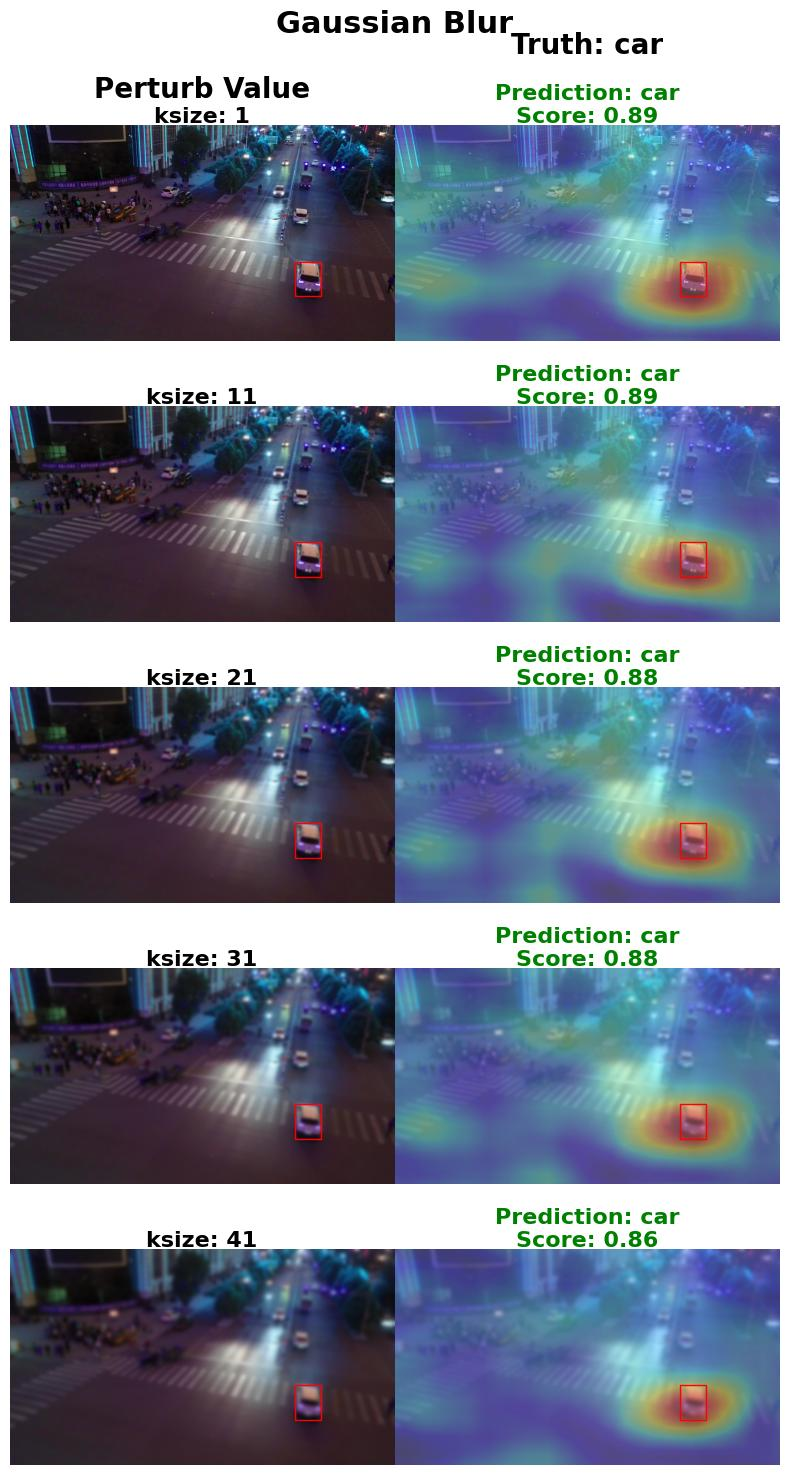

In [15]:
blur_perturbation_values = [aug.ksize for aug in blur_augmentations]

_, ax = visualize_saliency(
    [
        results[f"GaussianBlurPerturber_ksize_{int(val)}"]["perturbed_images"][example_img_id]
        for val in blur_perturbation_values
    ],
    [
        results[f"GaussianBlurPerturber_ksize_{int(val)}"]["truth_labels"][example_img_id]
        for val in blur_perturbation_values
    ],
    [results[f"GaussianBlurPerturber_ksize_{int(val)}"]["bboxes"][example_img_id] for val in blur_perturbation_values],
    [
        results[f"GaussianBlurPerturber_ksize_{int(val)}"]["sal_maps"][example_img_id]
        for val in blur_perturbation_values
    ],
    [
        results[f"GaussianBlurPerturber_ksize_{int(val)}"]["pred_labels"][example_img_id]
        for val in blur_perturbation_values
    ],
    [
        results[f"GaussianBlurPerturber_ksize_{int(val)}"]["pred_scores"][example_img_id]
        for val in blur_perturbation_values
    ],
    "ksize",
    blur_perturbation_values,
    "Gaussian Blur",
    0,
)

From the experiment results, we can see that increasing the blur intensity has little to no impact on detection performance. The confidence score decreases only slightly, indicating that the detection remains highly reliable.

This robustness can be explained by two key factors:

- **Object Size** – Larger objects in the scene are less sensitive to blur effects.
- **Object Location** – The position of the object within the image contributes to maintaining stable detection confidence.

As a result, even with higher levels of blur, the saliency map shows more focused clustering on the detected object. This effect is especially noticeable when smaller pedestrian objects are also present in the scene, making the main object stand out more clearly under blur conditions.

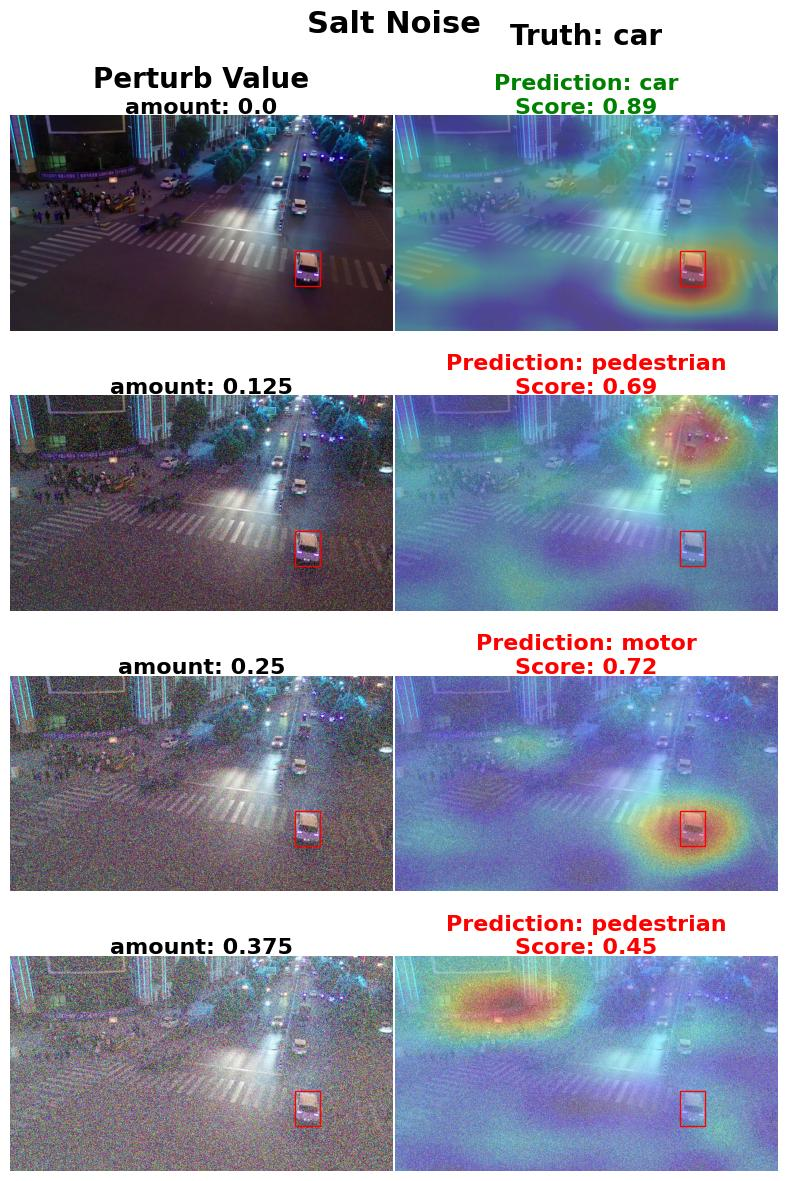

In [16]:
salt_perturbation_values = [aug.amount for aug in salt_augmentations]
salt_perturbation_values = salt_perturbation_values[:-1]  # exclude the last one due to no predicted detections

fig, ax = visualize_saliency(
    [
        results[f"SaltNoisePerturber_amount_{val}"]["perturbed_images"][example_img_id]
        for val in salt_perturbation_values
    ],
    [results[f"SaltNoisePerturber_amount_{val}"]["truth_labels"][example_img_id] for val in salt_perturbation_values],
    [results[f"SaltNoisePerturber_amount_{val}"]["bboxes"][example_img_id] for val in salt_perturbation_values],
    [results[f"SaltNoisePerturber_amount_{val}"]["sal_maps"][example_img_id] for val in salt_perturbation_values],
    [results[f"SaltNoisePerturber_amount_{val}"]["pred_labels"][example_img_id] for val in salt_perturbation_values],
    [results[f"SaltNoisePerturber_amount_{val}"]["pred_scores"][example_img_id] for val in salt_perturbation_values],
    "amount",
    salt_perturbation_values,
    "Salt Noise",
    0,
)

When adding even a small amount of salt noise, the detection performance changes drastically. Unlike blur, salt noise causes the confidence score to drop sharply, making the detection far less reliable.

Observations from the set of results above (each example after the first one adds in an incremental amount of salt noise):

- The first example is the unperturbed predicted detection.
- In the second example, the model shifts its attention to ``pedestrian`` focused areas as soon as a slight amount of salt noise is introduced.
- In the third example, the model loses focus again and shifts attention to irrelevant areas — in this case, clustering around a random region near the top-right of the image.
- In the fourth example, the model focuses on a random region in the top-left of the image similar to the second example. 

This shows that the model is highly sensitive to salt noise, which disrupts the feature patterns, leading to inconsistent detections.

## Conclusion

Based on visualizing the saliency maps on two different perturbed object detection image samples, we were able to observe how the model's predictions reinforced larger detections as the blur intensity increased. On the other hand, we also observed how a small amount of salt noise could throw away the predictive accuracy and consistency of the model by shifting focus to regions of the image that were away from the target object class.

Similarly, through this NRTK-XAITK Perturbation Saliency analysis, we presented an end-to-end workflow that enables modular interpretability and explainability of an Object Detection model's and dataset's robustness to natural or physics-based perturbations.